# Quantum Auto Encoder (QAE)

In [1]:
import os
import sys
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_machine_learning.connectors import TorchConnector
from compose_mnist_dataset import ComposeMnistDataset


In [2]:
n_qubits = 16
size = 4

In [3]:
dataset = ComposeMnistDataset(64, 64, 32, 32, 0, False)
train_loader, test_loader = dataset.exec(filter=[0, 1], size=(size, size))


In [4]:
def show_samples(images, labels, size, label_txt=None):
    num_samples = len(labels)
    num_row = 1
    num_col = num_samples
    plt.figure(figsize=(2 * num_col, 2 * num_row))
    for i in range(num_samples):
        plt.subplot(num_row, num_col, i + 1)
        plt.imshow(images[i].reshape(size, size), cmap="gray")
        if label_txt is not None:
            plt.title(f"{label_txt}: {labels[i]}")
        else:
            plt.title(labels[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()


In [5]:
def save_model(model, save_dir="./", filename="best_model.pth"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, filename))

In [6]:
def create_qnn(n_qubits: int):
    feature_map = ZFeatureMap(n_qubits)
    ansatz = RealAmplitudes(n_qubits, reps=2)
    qc = QuantumCircuit(n_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    observable = [
                    SparsePauliOp.from_list([("I"*(n_qubits-1) + "Z", 1)]),
                    SparsePauliOp.from_list([("I"*(n_qubits-2) + "Z" + "I", 1)])
                  ]
    backend = AerSimulator()
    pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
    isa_circuit = pm.run(qc)
    estimator = Estimator()
    qnn = EstimatorQNN(
        circuit = isa_circuit.decompose(),
        observables = observable,
        input_params = feature_map.parameters,
        weight_params = ansatz.parameters,
        estimator=estimator
    )
    return qnn

In [7]:
qnn = create_qnn(n_qubits)
quantum_layer = TorchConnector(qnn)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [8]:
class Decoder(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, output_dim=64):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.tanh(x)
        return x

In [9]:
class QVAE(nn.Module):
    def __init__(self, output_dim):
        super(QVAE, self).__init__()
        self.encoder = quantum_layer
        self.decoder = Decoder(output_dim=output_dim)

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent

In [10]:
model = QVAE(output_dim=n_qubits)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train(model, train_loader, epochs=5):
    best_loss = sys.maxsize
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            start = time.time()
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_loss /= len(train_loader)
            elapsed = time.time() - start
            if total_loss < best_loss:
                save_model(model)
                best_loss = total_loss
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Time: {elapsed:0.2f} sec")


In [12]:
train(model, train_loader)


Epoch [1/5], Loss: 0.2476, Time: 113.59 sec
Epoch [2/5], Loss: 0.2381, Time: 112.68 sec
Epoch [3/5], Loss: 0.2324, Time: 113.52 sec
Epoch [4/5], Loss: 0.2248, Time: 112.42 sec
Epoch [5/5], Loss: 0.2116, Time: 111.07 sec


In [13]:
model.load_state_dict(torch.load("./best_model.pth"))
model.eval()


QVAE(
  (encoder): TorchConnector()
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=32, bias=True)
    (relu): ReLU()
    (linear2): Linear(in_features=32, out_features=16, bias=True)
    (tanh): Tanh()
  )
)

In [14]:
test_dataset = next(iter(test_loader))

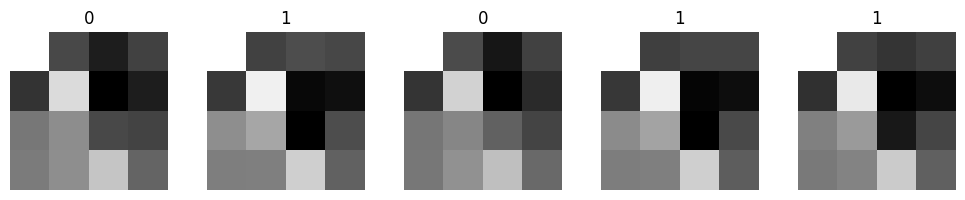

In [15]:
idxs_test = np.random.choice(len(test_dataset[1]), 5, replace=False)
test_images = []
test_labels = []
result = []
latents = []
for idx in idxs_test:
    test_image = test_dataset[0][idx]
    test_image = test_image.view(test_image.size(0), -1)
    test_images.append(test_image)
    test_labels.append(test_dataset[1][idx].item())

for test_image in test_images:
    outputs, latent = model(test_image)
    result.append(outputs.cpu().detach().numpy().copy())
    latents.append(latent.cpu().detach().numpy().copy())
latents = np.vstack(latents)
show_samples(
    result,
    test_labels,
    4
)


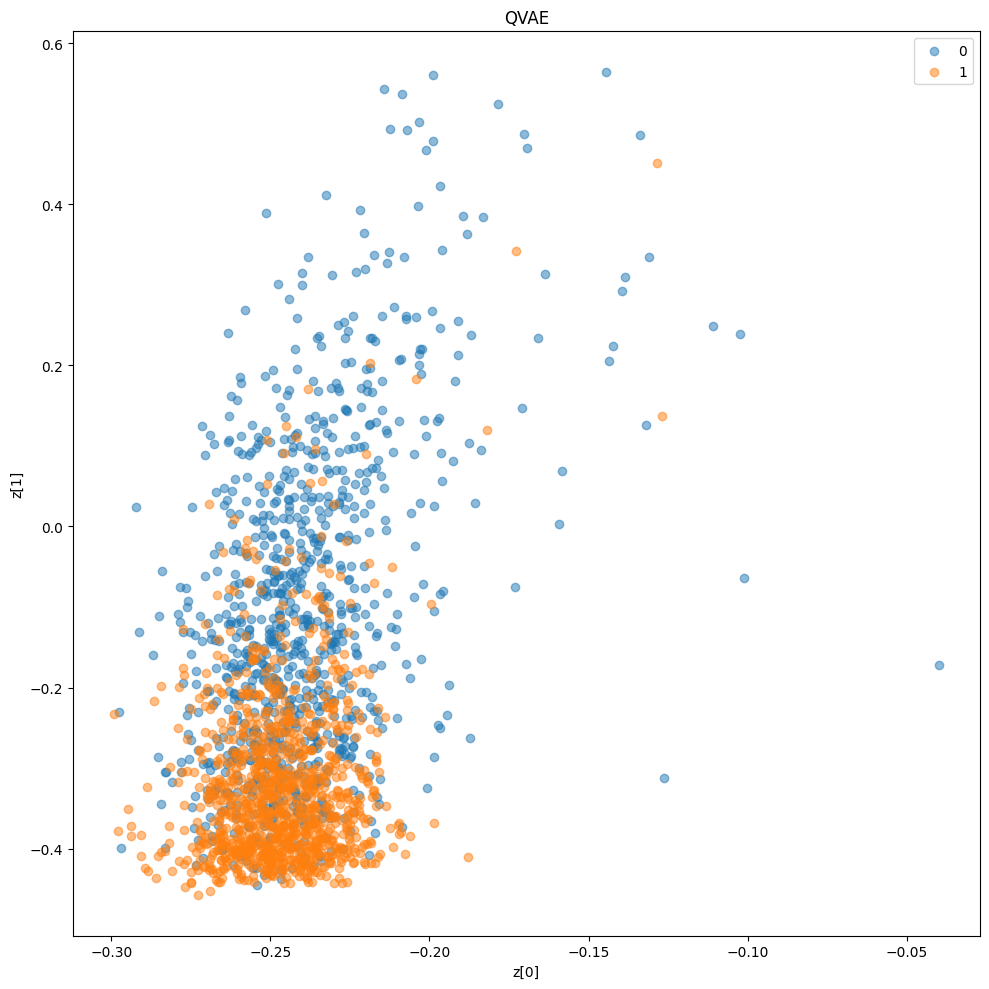

In [17]:
dataset = ComposeMnistDataset(None, None, 32, 2000, 0, False)
train_loader, test_loader = dataset.exec(filter=[0, 1], size=(size, size))

test_dataset = next(iter(test_loader))

idxs_test = np.random.choice(len(test_dataset[1]), 2000, replace=False)
test_images = []
test_labels = []
result = []
latents = []
for idx in idxs_test:
    test_image = test_dataset[0][idx]
    test_image = test_image.view(test_image.size(0), -1)
    test_images.append(test_image)
    test_labels.append(test_dataset[1][idx].item())

for test_image in test_images:
    outputs, latent = model(test_image)
    result.append(outputs.cpu().detach().numpy().copy())
    latents.append(latent.cpu().detach().numpy().copy())
latents = np.vstack(latents)

def visualize_features(latent_vectors: np.ndarray, labels: np.ndarray, model_name: str) -> None:
    plt.figure(figsize=(10, 10))
    unique_labels = np.unique(labels)

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        x_vals, y_vals = latent_vectors[indices].T
        plt.scatter(x_vals, y_vals, label=str(label), alpha=0.5)

    plt.legend()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(model_name.upper())
    plt.tight_layout()
    plt.show()
    plt.close()

visualize_features(latents, test_labels, "qvae")